# Sunsplots forecasting with an autoregressive neural network
### Inteligencia Artirficial para los Sistemas de Control Autónomos
### Máster de Ciencia y Tecnología desde el Espacio


## Objectives

- Use modern neural networks tools
- Illustrate a realistic Machine Learning workflow
- Design a neural network for regression
- Design an autoregressive neural network

## Introduction

Time-series forecasting is one of the most relevant neural networks tasks, with multiple applications in Space domain, from condition-based maintenance to Space Weather prediction.

In this assignment we will train neural networks to forecast a well-known time-series: the number of sunpots; this is actually the longest time-series recorded with uninterrupted data from 1789. This time-series presents a strong seasonality with 11-years cycles, which makes autorregresive modeling a good choice. 

Remember that the workflow usually implemented in ML projects is as follows.

1. Data adquisition
2. Exploratory analysis
3. Data preprocessing
4. Model training
5. Model validation

## Preliminary steps

The dataset has been taken from Kaggle, a pretty popular website among the Machine Learning community. Take some time to explore the [dataset](https://www.kaggle.com/robervalt/sunspots), but you will not need to download it because this notebook automatically downloads the dataset from [Internet](https://gist.githubusercontent.com/dfbarrero/466ad8dc4fc904bb2de1d69ef61319f1/raw/7feea731c24e2a8149731f27c6d66518e542a836/Sunspots.csv).

## Import libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import mean_squared_error

from datetime import timedelta

## Define some utility functions

Your do not need to understand this, thay are just utility functions to maintain a nicer code.

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

def plot_predict(observed, predicted):
  plt.figure(figsize=(20, 10))
  plt.plot(observed)
  plt.plot(predicted, linestyle="dashed")
  #plt.title('Observation vr. prediction')
  plt.ylabel('Sunspots')
  plt.xlabel('Index')
  plt.legend(['Observed', 'Predicted'], loc='upper right')
  plt.show()

def plot_histograms(observed, predicted):
    """
    Plot two side-by-side histograms with the observed and predicted sunspots
    """
    #plt.figure(figsize=(40, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.histplot(predicted, ax=ax2);
    ax2.title.set_text("Predictions")
    sns.histplot(observed, ax=ax1);
    ax1.title.set_text("Observations")

def plot_train_test(train, test):
    plt.figure(figsize=(20, 6));
    sns.lineplot(data = train, color="blue")

    x = range(len(train), len(train) + len(test))
    sns.lineplot(x=x, y=test, color="red", linestyle="dotted")
    plt.ylabel("Observed sunspots");

def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

def split_timeseries(dataset, ratio=0.8):
    '''
      dataset[:, 0] must contain the target
    '''
    split_time = int(ratio * len(dataset))

    train = dataset[:split_time]
    test = dataset[split_time:]

    print("Number of instances: " + str(len(dataset)))
    print("Number of instances for train: " + str(split_time))
    print("Number of instances for validation: " + str(len(dataset) - split_time))

    plt.figure(figsize=(20, 6));
    plt.plot(train['Sunspots']);
    plt.plot(test['Sunspots'], linestyle="dotted");
    plt.xlabel("Year");
    plt.ylabel("Observed sunspots");
    plt.legend(['Train', 'Test'], loc='upper right')

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

    return X_train, y_train, X_test, y_test

## Load dataset

In [ ]:
sunspots = pd.read_csv('https://gist.githubusercontent.com/dfbarrero/466ad8dc4fc904bb2de1d69ef61319f1/raw/7feea731c24e2a8149731f27c6d66518e542a836/Sunspots.csv', parse_dates = [1], index_col = 1).drop(columns=['Unnamed: 0'])
sunspots.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


Let's change the second column name to something shorter.

In [ ]:
sunspots.rename(columns = {'Monthly Mean Total Sunspot Number':'Sunspots'}, inplace = True)
sunspots.head()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


## Exploratory analysis

Always observe your data before doing any futher processing.

In [ ]:
sunspots.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


In [ ]:
sunspots.describe()

,Sunspots
count,3265.000000
mean,81.778775
std,67.889277
min,0.000000
25%,23.900000
50%,67.200000
75%,122.500000
max,398.200000


Our dataset has 3265 instances, from 1749-03-31 to 2021-01-31. Let's plot the time-serie.

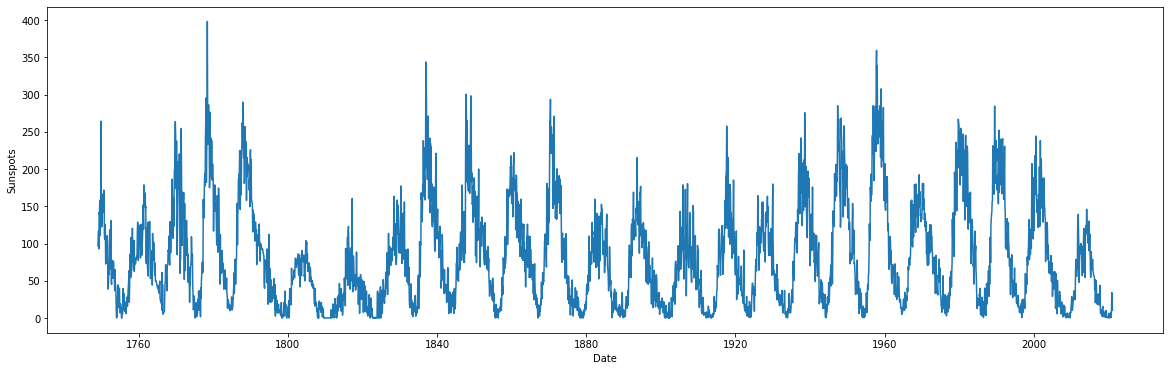

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(x="Date", y="Sunspots", data=sunspots);

The seasonality of our time-serie is clear looking at the previous figure. Now let's observe in more detail a 11-years long time-series.

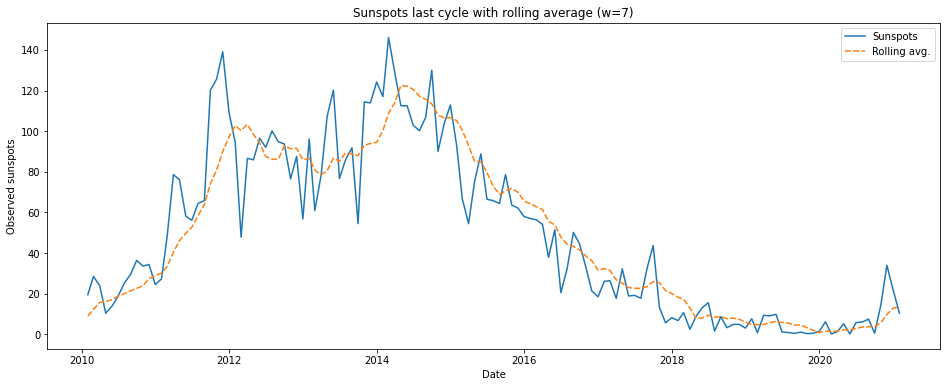

In [ ]:
# Last 11 years
last = sunspots.copy()
last['Rolling avg.'] = last.rolling(window=7).mean()

plt.figure(figsize=(16, 6))
sns.lineplot(data = last.loc['2010-01': '2021-01'])
plt.title("Sunspots last cycle with rolling average (w=7)");
plt.ylabel("Observed sunspots");

del last;

The time-series seems clean and without outliers. Let's make more plots to be sure.

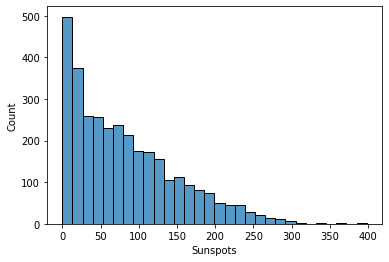

In [ ]:
sns.histplot(data=sunspots, x="Sunspots");

Autocorrelation diagrams are an amazing tool to study stationality. The next one depicts the autocorrelation of our time-series along with vertical lines that represent 11 years periods. If you do not know what an autocorrelation diagram is, google it and enjoy.

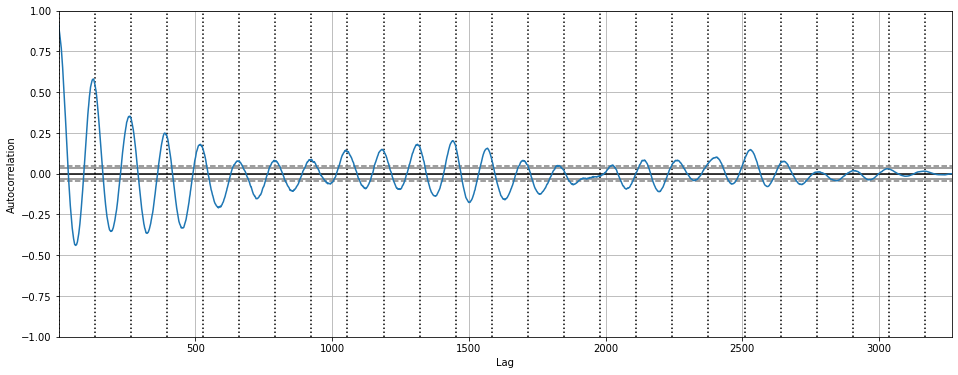

In [ ]:
plt.figure(figsize=(16, 6));
pd.plotting.autocorrelation_plot(sunspots['Sunspots']);
cycles = [x*11*12 for x in np.arange(25)]
plt.vlines(cycles, -1, 1, linestyles="dotted");

STL (Seasonal and Trend) decomposition is another amazing tool in time-series analysis. Google it if you need more info about it.

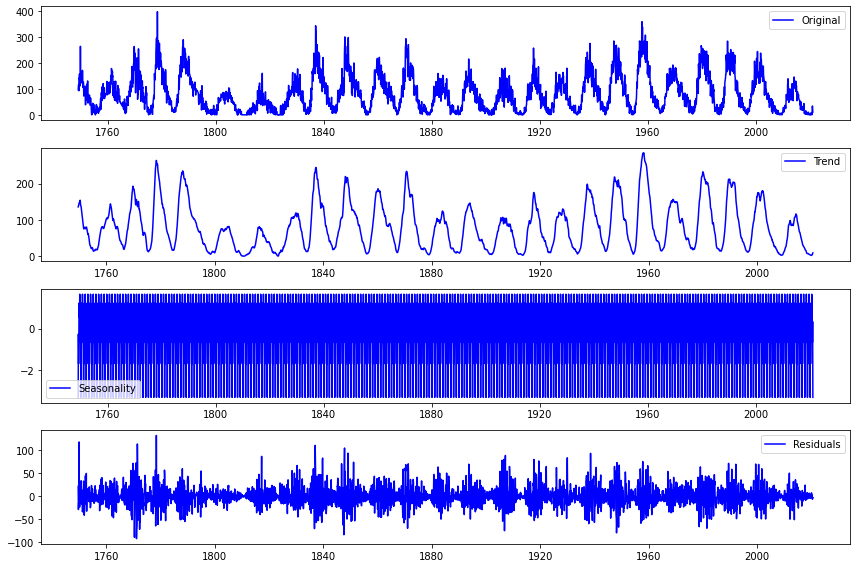

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sunspots['Sunspots'], model='additive')


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(sunspots['Sunspots'], label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

## Preprocess data

We first need a target variable to train our regressor. Our goal is to forecast with a time horizon of one month, so, we will add the target attribute just shifting our time-series one month.

In [ ]:
#@title Forcasting horizon
days = 30 #@param {type:"slider", min:30, max:150, step:30}


dataset_phased = sunspots.copy()
dataset_phased.reset_index(inplace=True)
dataset_phased['Date'] = dataset_phased['Date'].apply(lambda x: x + timedelta(days=days))
dataset_phased.set_index('Date', inplace=True)

Group observations by month.

In [ ]:
dataset_phased = dataset_phased.groupby(pd.Grouper(freq='1M')).mean()
sunspots = sunspots.groupby(pd.Grouper(freq='1M')).mean()

Join phased and non-phased data.

In [ ]:
new_cols = [c+'_phased' for c in dataset_phased.columns]
dataset_phased.columns = new_cols
#combined = dataset_phased.join(sunspots)
combined = sunspots.join(dataset_phased)
combined.rename(columns = {'Sunspots':'Target'}, inplace = True)
combined.rename(columns = {'Sunspots_phased':'Sunspots'}, inplace = True)
combined.head()

,Target,Sunspots
Date,,
1749-01-31,96.7,NaN
1749-02-28,104.3,NaN
1749-03-31,116.7,NaN
1749-04-30,92.8,NaN
1749-05-31,141.7,NaN


In [ ]:
print('NaNs in Target: ' + str(combined['Target'].isna().sum()))
print('NaNs in Target: ' + str(combined['Sunspots'].isna().sum()))

NaNs in Target: 0
NaNs in Target: 5


Observe that we have NaNs (NaN = not a number), this is quite dangerous and must be solved. We have decided to interpolate missing data as follows.

In [ ]:
combined.interpolate(inplace=True)

print('NaNs in Target: ' + str(combined['Target'].isna().sum()))
print('NaNs in Target: ' + str(combined['Sunspots'].isna().sum()))
print()
combined['Sunspots'].head()

NaNs in Target: 0
NaNs in Target: 5



Date
1749-01-31   NaN
1749-02-28   NaN
1749-03-31   NaN
1749-04-30   NaN
1749-05-31   NaN
Freq: M, Name: Sunspots, dtype: float64

There are still two NaNs, we simply remove them.

In [ ]:
combined = combined.dropna()

print('NaNs in Target: ' + str(combined['Target'].isna().sum()))
print('NaNs in Sunspots: ' + str(combined['Sunspots'].isna().sum()))

NaNs in Target: 0
NaNs in Sunspots: 0


Now we have a clean and beautiful dataset to begin with.

In [ ]:
combined

,Target,Sunspots
Date,,
1749-06-30,139.2,96.7
1749-07-31,158.0,104.3
1749-08-31,110.5,116.7
1749-09-30,126.5,92.8
1749-10-31,125.8,141.7
...,...,...
2020-09-30,0.6,5.2
2020-10-31,14.4,0.2
2020-11-30,34.0,5.8


## Set up a baseline

In order to assess correctly our model metrics, we first need something to compare with. Absolute metrics have little meaning without a context. To this end it is quite common to apply a dumb forecasting just to have an estimation of the magnitude of the metrics. In our case we will simply predict one month in advance with the last observation of the number of sunspots, in other words, we will propagate our last observation and compute its metrics.

In [ ]:
rmse = mean_squared_error(combined['Sunspots'], combined['Target'], squared=False)
print(f"RMSE: {rmse}")

RMSE: 37.784298277446126


Any predictive model should get a RMSE lower than 26.8, otherwise it will be fail miserably (and this is something that could happen). Take into account that RMSE is defined as

$RMSE = \sqrt {\sum_i{\frac{(P_i-O_i)}{n}}}$

Let's visualize our baseline prediction.

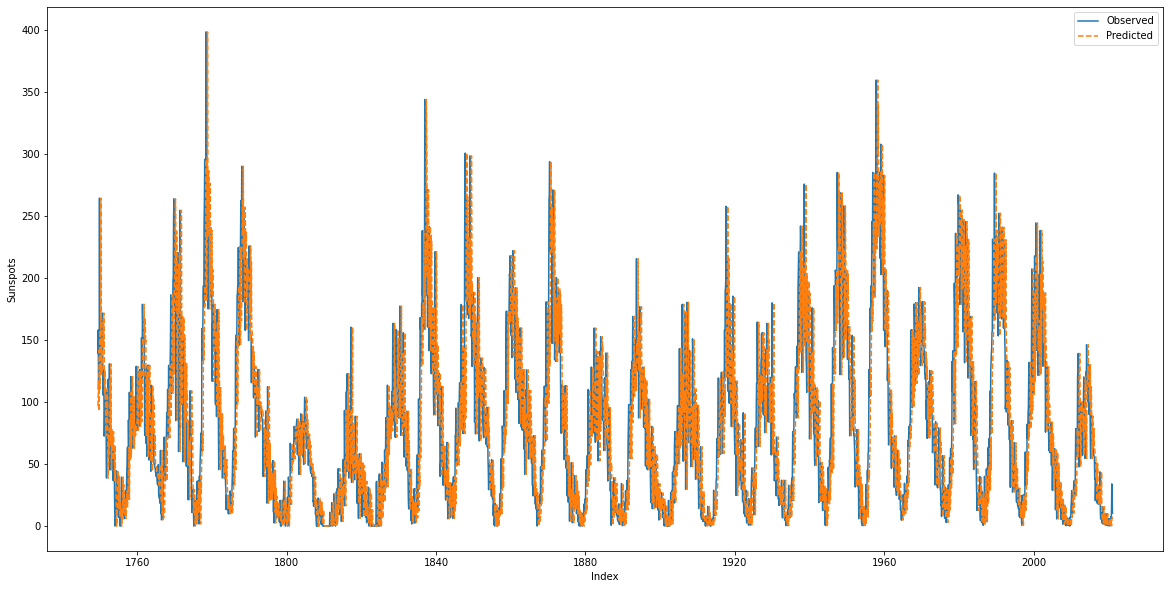

In [ ]:
plot_predict(combined['Target'], combined['Sunspots'])

The prediction looks pretty good despite of its simplicity, however we want a model performing better.

## Predictive modelling: Multilayer Perceptron (MLP)

We first will train a very simple MLP to predict the number of sunspots. 

### Import new libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

## Preprocess data for predictive modelling

### Split train and validation datasets

Number of instances: 3260
Number of instances for train: 2608
Number of instances for validation: 652


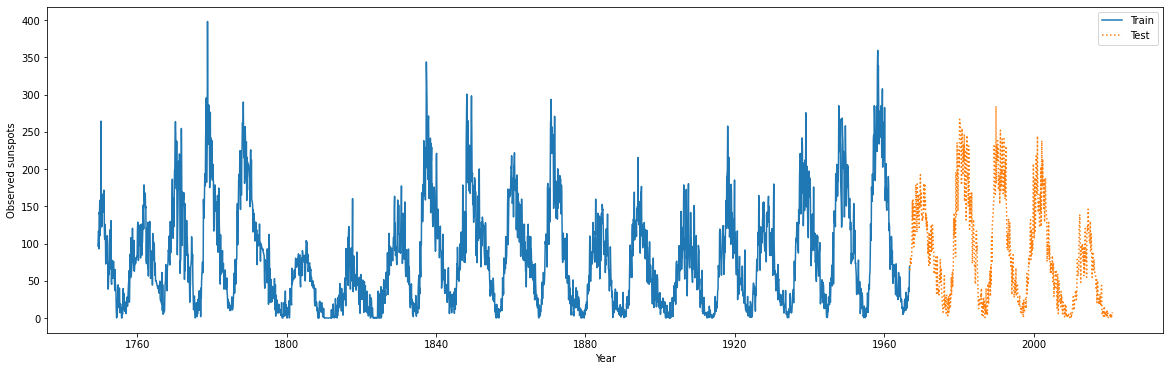

In [ ]:
x_train, y_train, x_test, y_test = split_timeseries(combined, ratio=0.8)



### Data normalization

This is needed by any neural network. We first train our scaler.

In [ ]:
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

scalerX.fit(x_train)
scalerY.fit(y_train.to_frame().values.reshape(-1,1))

MinMaxScaler()

And now we can scale our data.

In [ ]:
scaled_train_x = scalerX.transform(x_train)
scaled_train_y = scalerY.transform(y_train.to_frame().values.reshape(-1,1))

scaled_test_x = scalerX.transform(x_test)
scaled_test_y = scalerY.transform(y_test.to_frame().values.reshape(-1,1))



---



---



### Model definition

Here is where the interesting stuff begins. We first set up some parameters.

In [ ]:
mlp_epochs = 30
mlp_dropout = 0.1 
mlp_batch = 50 
mlp_optimizer = "adam" 
mlp_activation = "relu" 

The following lines define the network topology along with its activation functions.

In [ ]:
mlp = Sequential()

mlp.add(Dense(20, activation=mlp_activation, input_shape= (1,)))
mlp.add(Dense(20, activation=mlp_activation))
mlp.add(Dropout(mlp_dropout))
mlp.add(Dense(1, activation='linear'))

Please observe that the last layer has a 'linear' activation function and the input layer is composed by a single neuron; it means that this network only considers one observation to predict one month in advance. As a consequence, the network has very limited data to make predictions, which in this simple example is not a great deal, but in a more realistic scenario should be troublesome.

Next, we print the model architecture. It is important to note that the model complexity is given by the number of parameters we must optimize, which is obtained with the following order.

In [ ]:
mlp.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 20)                40        
                                                                 
 dense_73 (Dense)            (None, 20)                420       
                                                                 
 dropout_24 (Dropout)        (None, 20)                0         
                                                                 
 dense_74 (Dense)            (None, 1)                 21        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


This network has 481 parameters, with is very limited in comparison with modern deep networks but pretty big for the single problem we face here.

A plot of the model is easier to understand.

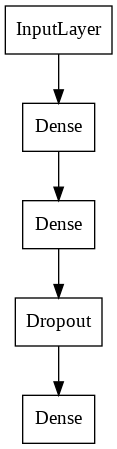

In [ ]:
keras.utils.plot_model(mlp, show_layer_names=False)

### Model training

Finally, we are ready to train the network. This operation, depending on the network complexity and amount of data may take a long time, weeks in high-end models with large amounts of data. For this reason hardware acceleration is a must in Deep Learning, but in this simple example it is not quiredes. In any case, you may want to activate TPU acceleration in Google Colab in this point (Edit->Notebook settings). In real-world, setting up a computer with GPU/TPU acceleration is quite complex, but Google Colab makes it straightforward.

The following line initializes backpropagation with an adam optimizer, but it is not executed.

In [ ]:
mlp.compile(optimizer=mlp_optimizer, loss='mae')

... and here we go! We fit the model for 30 epochs and a batch size of 50. Enjoy watching the evolution of the validation loss.

In [ ]:
history = mlp.fit(scaled_train_x, scaled_train_y, epochs=mlp_epochs, batch_size=mlp_batch, 
          validation_data=(scaled_test_x, scaled_test_y))

Epoch 1/30
53/53 [==============================] - 1s 5ms/step - loss: 0.1041 - val_loss: 0.0766
Epoch 2/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0627
Epoch 3/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0621
Epoch 4/30
53/53 [==============================] - 0s 3ms/step - loss: 0.0711 - val_loss: 0.0621
Epoch 5/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0621
Epoch 6/30
53/53 [==============================] - 0s 3ms/step - loss: 0.0700 - val_loss: 0.0622
Epoch 7/30
53/53 [==============================] - 0s 3ms/step - loss: 0.0692 - val_loss: 0.0628
Epoch 8/30
53/53 [==============================] - 0s 3ms/step - loss: 0.0706 - val_loss: 0.0624
Epoch 9/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0633
Epoch 10/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0622
Epoch 11/30
53/53 [

The evolution of the loss is quite informative, and should be visualized.



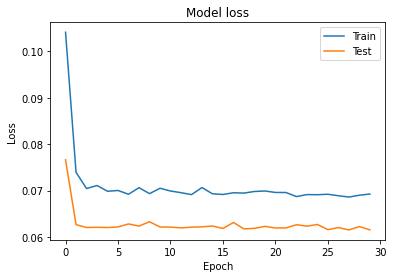

In [ ]:
plot_loss(history)

## Model validation

Compute the model performance, the network output is scaled, so we must unscale it before using it to obtain unscaled performance metrics.

In [ ]:
mlp_predict_scaled = mlp.predict(scaled_test_x)
# Unscale our prediction 
mlp_predict = scalerY.inverse_transform(mlp_predict_scaled)

Now we can compute the MSE (*Mean Squared Error*) over our unscaled data.

In [ ]:
rmse_mlp = mean_squared_error(y_test.values, mlp_predict, squared=False)
print(f"RMSE MLP: {rmse_mlp}")

RMSE MLP: 33.300152188355575


It seems that our neuronal regressor behaves a bit better (RMSE=24.2) than our baseline (26.8). 

Finally we overlap the observed data with the predicted one to better understand our model performance. Please take into account that the plot only depicts the validation dataset.

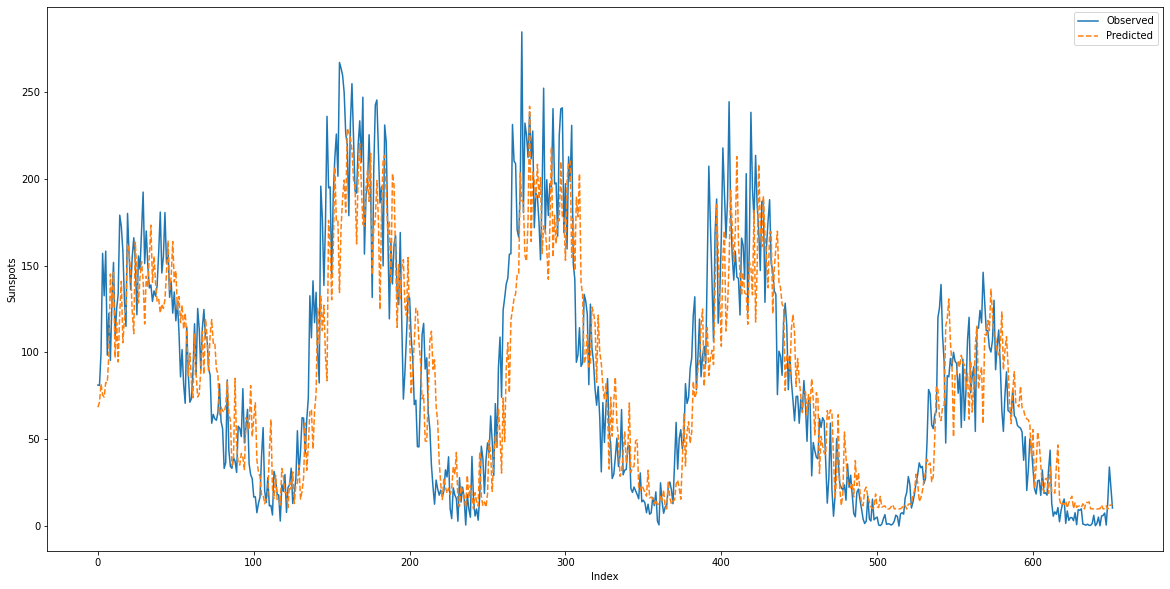

In [ ]:
plot_predict(y_test.values, mlp_predict)

Sometimes it is interesting to compare the statistical properties of the observed data with the predicted data.

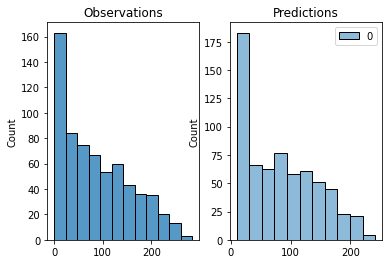

In [ ]:
plot_histograms(y_test.values, mlp_predict);

Getting an additional metric such as the correlation coefficient between observed and predicted data might be interesting.

In [ ]:
r_mlp, p_value = pearsonr(y_test.values, mlp_predict)

print(f'Pearson\'s correlation coefficient:\t{r_mlp}')
print(f'p-value:\t\t\t\t{p_value}')

Pearson's correlation coefficient:	[0.8781392409648888]
p-value:				2.6232930818507368e-210


The correlation is higher than 0.9, which is pretty high and suggests that our model is fitting quite well. 

## Autoregressive (AR) model

This section contains code from https://www.kaggle.com/nitinsss/time-series-prediction-with-keras-for-beginners

The next cell preprocess the sunspots time-series to train an autoregressive forcasting model. Autoregressive models use a time window, as shown in the figure. It incorporates in the time-serie relevant information implicitly contained in itself.

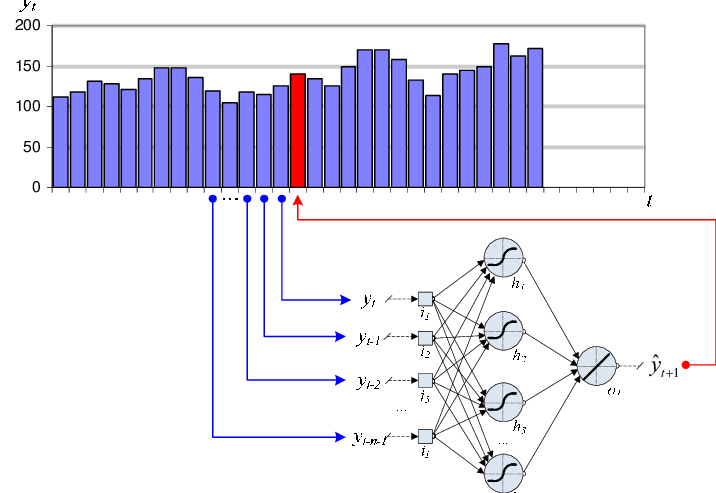

Observe the following dataset and the figure above, can you understand what an autoregressive model is?.

In [ ]:
t_instants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

ar_data = create_regressor_attributes(combined.copy(), ["Sunspots"], t_instants)

ar_data.head()

,Target,Sunspots,Sunspots_(t-1),Sunspots_(t-2),Sunspots_(t-3),Sunspots_(t-4),Sunspots_(t-5),Sunspots_(t-6),Sunspots_(t-7),Sunspots_(t-8),Sunspots_(t-9),Sunspots_(t-10),Sunspots_(t-11),Sunspots_(t-12),Sunspots_(t-13),Sunspots_(t-14),Sunspots_(t-15)
datetime,,,,,,,,,,,,,,,,,
1750-09-30,152.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7
1750-10-31,109.5,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3
1750-11-30,105.5,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7
1750-12-31,125.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8
1751-01-31,116.7,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7


### Split train and validation datasets

Number of instances: 3245
Number of instances for train: 2596
Number of instances for validation: 649

Shape of training inputs, training target: (2596, 16) (2596,)
Shape of test inputs, test target: (649, 16) (649,)



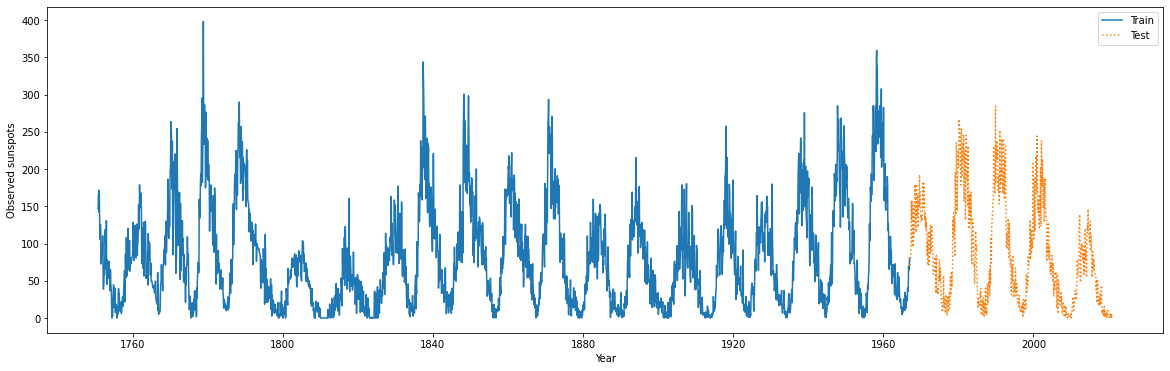

In [ ]:
x_train_ar, y_train_ar, x_test_ar, y_test_ar = split_timeseries(ar_data, ratio=0.8)

#y_train_ar = y_train_ar.to_numpy()
#y_test_ar = y_test_ar.to_numpy()

print('\nShape of training inputs, training target:', x_train_ar.shape, y_train_ar.shape)
print('Shape of test inputs, test target:', x_test_ar.shape, y_test_ar.shape)
print('')


## Train scalers and scale data (AR)

In [ ]:
scaler_data_ar = MinMaxScaler()
scaler_target_ar = MinMaxScaler()

scaler_data_ar.fit(x_train_ar)
scaler_target_ar.fit(y_train_ar.to_numpy().reshape(-1, 1))

x_train_ar_scaled = scaler_data_ar.transform(x_train_ar)
x_test_ar_scaled = scaler_data_ar.transform(x_test_ar)

y_train_ar_scaled = scaler_target_ar.transform(y_train_ar.to_numpy().reshape(-1, 1))
y_test_ar_scaled = scaler_target_ar.transform(y_test_ar.to_numpy().reshape(-1, 1))

print('\nShape of training inputs, training target:', x_train_ar_scaled.shape, y_train_ar_scaled.shape)
print('Shape of test inputs, test target:', x_test_ar_scaled.shape, y_test_ar_scaled.shape)
print('')


Shape of training inputs, training target: (2596, 16) (2596, 1)
Shape of test inputs, test target: (649, 16) (649, 1)



## Model definition
The following cell defines some hyperparameters.

In [ ]:
#@title AR network parameters
ar_epochs = 30 #@param {type:"slider", min:10, max:500, step:10}
ar_dropout = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
ar_batches = 50 #@param {type:"number"}
ar_activation = "relu" #@param ["relu", "sigmoid", "softmax", "tanh"]
ar_optimizer = "adam" #@param ["adam", "sgd", "rmsprop", "adagrad"]

The following cell defines our AR neural network topolology.


In [ ]:
model_ar = Sequential()

model_ar.add(Dense(20, activation=ar_activation, input_shape= (16,)))
model_ar.add(Dense(20, activation=ar_activation))
model_ar.add(Dropout(ar_dropout))
model_ar.add(Dense(1, activation='linear'))

Compile our model.

In [ ]:
model_ar.compile(loss='mean_squared_error', optimizer=ar_optimizer)
model_ar.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 20)                340       
                                                                 
 dense_76 (Dense)            (None, 20)                420       
                                                                 
 dropout_25 (Dropout)        (None, 20)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 21        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


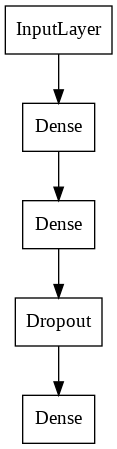

In [ ]:
keras.utils.plot_model(model_ar, show_layer_names=False)

In [ ]:
history = model_ar.fit(x=x_train_ar_scaled, y=y_train_ar_scaled, batch_size=ar_batches, epochs=ar_epochs, validation_data=(x_test_ar_scaled, y_test_ar_scaled), shuffle=False)

Epoch 1/30
52/52 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0069
Epoch 2/30
52/52 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0062
Epoch 3/30
52/52 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 4/30
52/52 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 5/30
52/52 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0054
Epoch 6/30
52/52 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 7/30
52/52 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 8/30
52/52 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 9/30
52/52 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 10/30
52/52 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 11/30
52/52 [

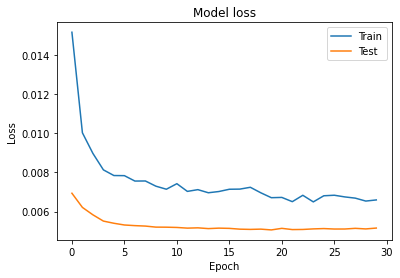

In [ ]:
plot_loss(history)

## Autoregressive model validation

In [ ]:
ar_predict_scaled = model_ar.predict(x_test_ar_scaled)
ar_predict = scaler_target_ar.inverse_transform(ar_predict_scaled)

print("RMSE AR scaled: " 
      + str(mean_squared_error(y_test_ar_scaled, ar_predict_scaled, squared=False)))

rmse_ar = mean_squared_error(y_test_ar, ar_predict, squared=False)

print(f"RMSE AR: {rmse_ar}")


RMSE AR scaled: 0.07180168189841313
RMSE AR: 28.591429592043287


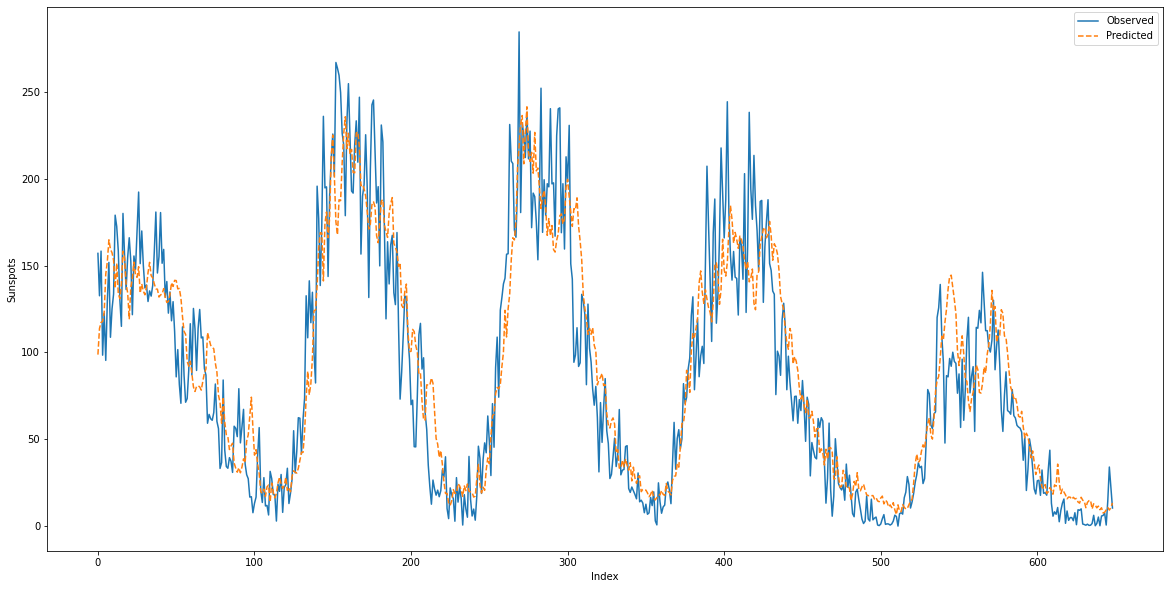

In [ ]:
plot_predict(y_test_ar.to_numpy(), ar_predict)

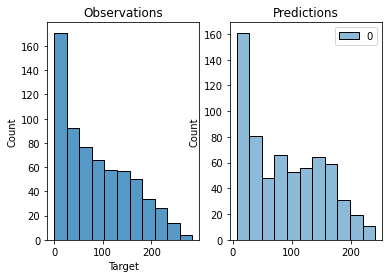

In [ ]:
plot_histograms(y_test_ar, ar_predict)

In [ ]:
r_ar, p_value = pearsonr(y_test_ar, ar_predict)

print(f'Pearson\'s correlation coefficient:\t{r_ar[0]}')

Pearson's correlation coefficient:	0.9122364578216481


## Model comparison
Finally, we compare the predictions given by the three models (baseline, ANN and AR).

In [ ]:
print(f"RMSE baseline: {rmse}")
print(f"RMSE MLP: {rmse_mlp}")
print(f"RMSE AR: {rmse_ar}")
print()
print(f"Pearson baseline: " + str(pearsonr(combined['Target'], combined['Sunspots'])[0]))
print(f"Pearson MLP: {r_mlp[0]}")
print(f"Pearson AR: {r_ar[0]}")

RMSE baseline: 37.784298277446126
RMSE MLP: 33.300152188355575
RMSE AR: 28.591429592043287

Pearson baseline: 0.8451708761214047
Pearson MLP: 0.8781392409648888
Pearson AR: 0.9122364578216481


Let's visualize the predictions.

RMSE baseline: 37.784298277446126


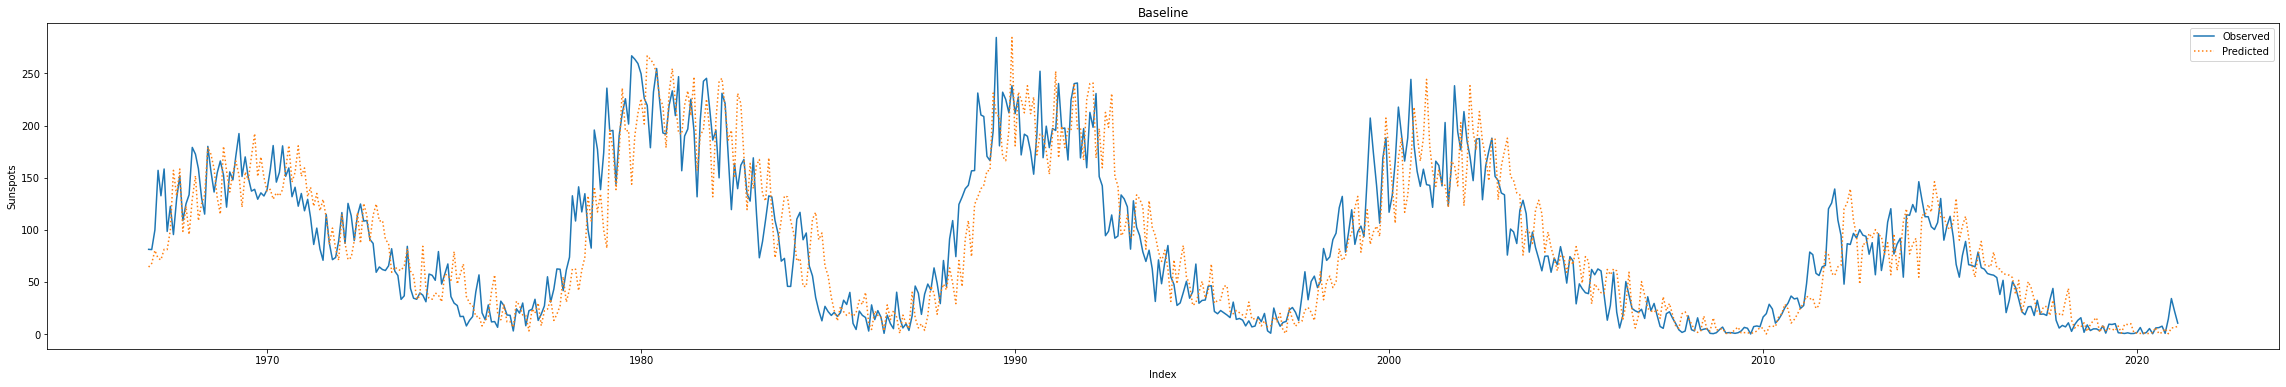

In [ ]:
length = len(mlp_predict)

mse = mean_squared_error(combined['Sunspots'], combined['Target'], squared=False)
print("RMSE baseline: " + str(mse))

plt.figure(figsize=(40,6))
plt.plot(combined['Target'].tail(length))
plt.plot(combined['Sunspots'].tail(length), linestyle="dotted")
plt.xlabel("Index");
plt.ylabel("Sunspots");
plt.title("Baseline")
plt.legend(['Observed', 'Predicted'], loc='upper right')

RMSE MLP 33.300152188355575


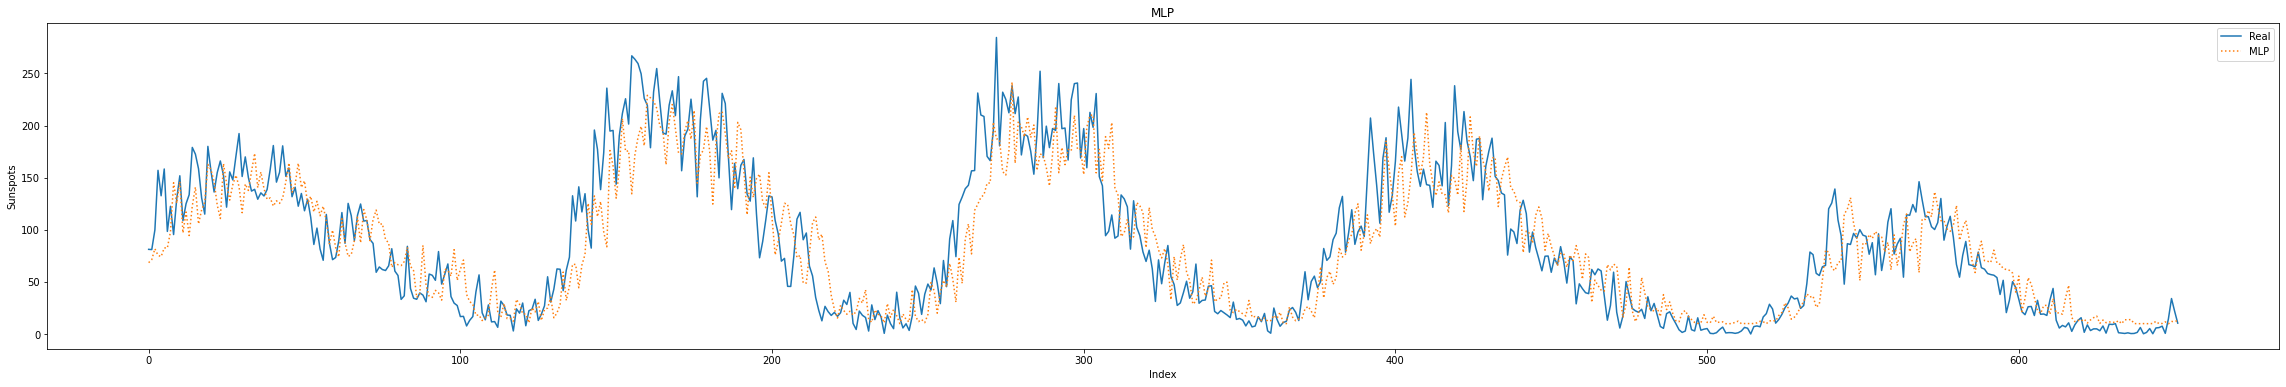

In [ ]:
plt.figure(figsize=(40, 6));
plt.plot(y_test.values)
plt.plot(mlp_predict, linestyle="dotted");
plt.xlabel("Index");
plt.ylabel("Sunspots");
plt.title("MLP")
plt.legend(['Real', 'MLP'], loc='upper right')

print("RMSE MLP " + str(mean_squared_error(y_test.values, mlp_predict, squared=False)))


RMSE AR 27.861026640894504


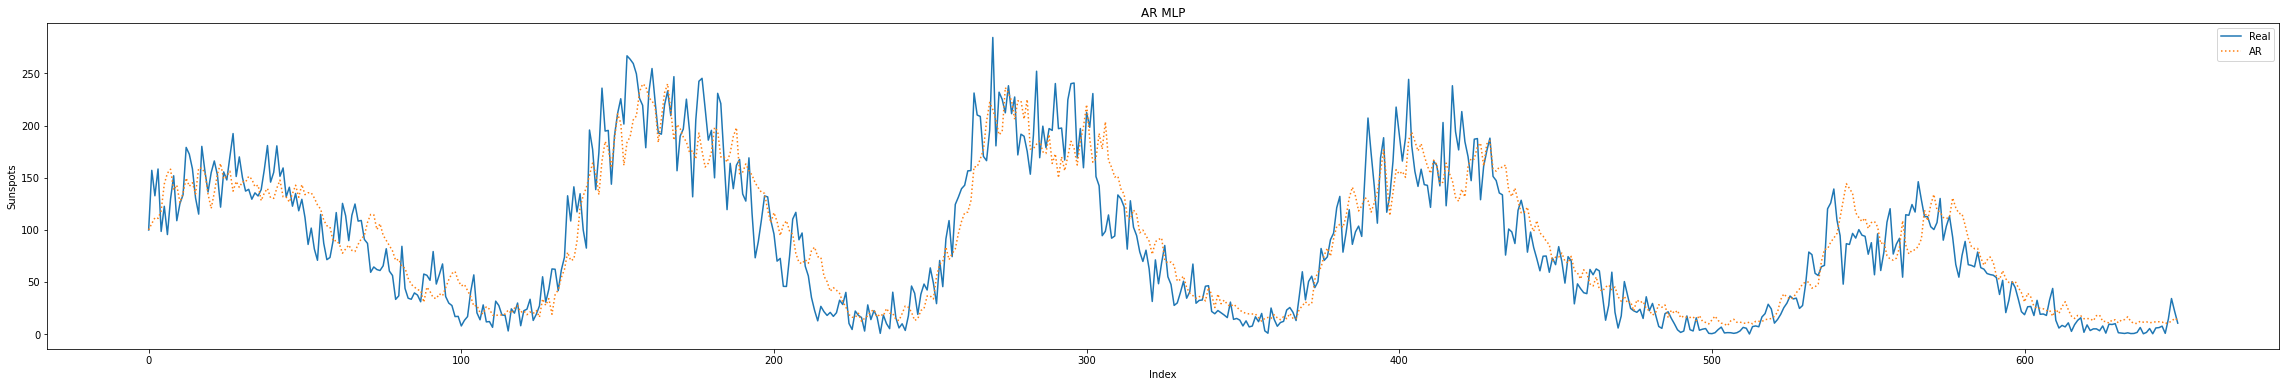

In [ ]:
plt.figure(figsize=(40, 6));
plt.plot(y_test_ar.values)
plt.plot(ar_predict, linestyle="dotted")
plt.xlabel("Index");
plt.ylabel("Sunspots");
plt.title("AR MLP")
plt.legend(['Real', 'AR'], loc='upper right')

print("RMSE AR " + str(mean_squared_error(y_test_ar, ar_predict, squared=False)))

# Exercises

The following exercises involve running several experiments with different hyperparameters. Use a spreadsheet or any other tool of your choice to store the configuration of each experiment along with its results. Each time you finish one question, do not forget to reset the default hyperparameters before moving forward the next one.

1. Understand the workflow implemented in this notebook. You do not need to understand the details of the code but of course it is better if you can understand that. 

   * Explain why the preprocessing phase generated NaNs on dates 1749-01-31 and
1749-02-28.

2. Do you think that the MLP model showed above is a good design?

3. Compare RMSE and correlation of the three models, do those metrics make sense? Does additional information included in the AR model help to enhance the prediction?

| Model | RMSE | Correlation |
| ---   | --- | --- | 
| Baseline   |     |    | 
| MLP   | | |
| AR    | | |

4. Observe that the activation function of the last layer is always linear. Train both models using a "sigmoid" activation function in the last layer, and observe how the MSE changes. Explain that.

| Output activation function | MLP RMSE | AR RMSE |
| ---   | --- |  --- |
| Linear   |     |   |
| Sigmoid   | | |

5. Model fitting depends on several hyperparameters, find out what they mean and try to fit models with different values of this parameters. Google if needed their meaning and interpret the results.

   - *Epochs*. Change this hyperparameters in the AR model and observe the loss function plot.

   - *Batch size*. Change this hyperparameters in the AR model and observe both, RMSE and training time.

   - *Activation functions*. Try the activation functions given in the following table and interpret the result. Use the AR model. Discuss the result with your instructor in case you need it.

| Optimizer | AR RMSE |
| ---   | --- | 
| Relu   |     |    
| Sigmoid   | | 
| Softmax    | | 
| Tanh    | | 

6. Try the *optimizers* given by the table and interpret the result. Use the AR model.

| Optimizer | AR RMSE |
| ---   | --- | 
| SGD   |     |    
| Rmsprop   | | 
| Adam    | | 
| Adagrad    | | 

7. Change the *dropout* layer in the AR model according to the table and interpret the result.

| Dropout | RMSE |
| ---   | --- | 
| 0   |     |    
| 0.1   | | 
| 0.2    | | 
| 0.5    | | 

8. Change forecasting horizon, fullfit the following table and explain any pattern you idenfify.

| Model | 30 days | 60 days | 120 days | 150 days |
| ---   | --- | --- | |  |
| RMSE baseline    |     |     | | |
| RMSE MLP   | | | | |
| RMSE AR    | | | | |

9. Train the best model you can for a 150 days time horizon by using any means at your hand, as long as you validate it correctly.
